In [1]:
import warnings
warnings.simplefilter(action='ignore')

In [2]:
from data_load import load_data
from data_visualization import (
                                visualize_volume_avg_hour,
                                visualize_vpin_and_gap_time
                            )
from data_processing import (
                            transform_avg_volume_hourly,
                             transform_buy_sell_volume,
                             calculate_V,
                             calculate_bucket_number,
                             calculate_vpin,
                             calcualate_gap_time_faction_of_the_day
                             )

In [3]:
# Load data
data_tick = load_data()
data_orderbook = load_data(folder= "orderbook")
data_vn30_index = load_data(folder = "")

## PHẦN 1: VOLUME THEO THỜI GIAN

In [4]:
key1 = "STB"
key2 = "SAB"
STB_avg_hourly, SAB_avg_hourly = transform_avg_volume_hourly(data_tick)
SAB_avg_hourly, STB_avg_hourly


(   Hour         KL
 0     9  58.772920
 1    10  54.110919
 2    11  42.729430
 3    13  55.199203
 4    14  54.119795,
    Hour          KL
 0     9  238.257788
 1    10  219.788697
 2    11  223.656007
 3    13  250.128809
 4    14  275.724979)

- Vì sàn chứng khoáng Việt Nam chỉ giao dịch từ:
    - 9h sáng 11h30 trưa
    - Nghỉ trưa từ 11h30 đến 13h chiều
    - Hoặt động lại từ 13h chiều đến 15h00 chiều
- Do đó dữ liệu theo giờ chỉ có ở các mốc 9, 10, 11, 13, 14 (làm tròn lùi theo giờ)

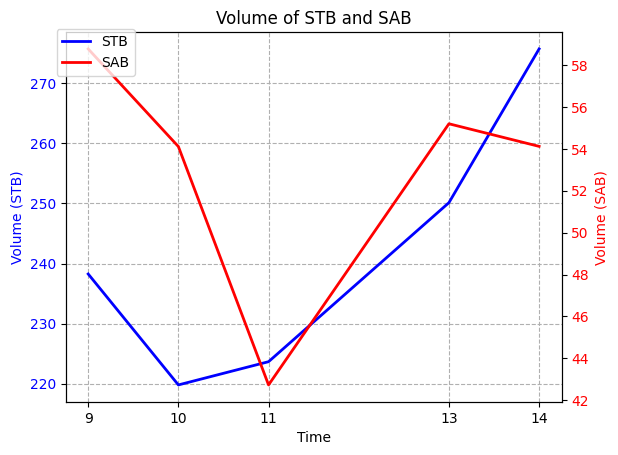

In [5]:
visualize_volume_avg_hour(STB_avg_hourly, SAB_avg_hourly)

## PHẦN 2: VPIN

In [6]:
# Chọn ra 1 loại cổ phiêú
key1 = "STB"
STB = transform_buy_sell_volume(data_orderbook, key1 = key1)
STB.head()

,Date,KL_mua,KL_ban,KL
0,2024-09-23 13:00:05,39880.0,119180.0,159060.0
1,2024-09-23 13:00:07,39740.0,0.0,39740.0
2,2024-09-23 13:00:09,0.0,60260.0,60260.0
3,2024-09-23 13:00:10,0.0,60470.0,60470.0
4,2024-09-23 13:00:13,39650.0,0.0,39650.0


In [7]:
# # Tính V
V, STB = calculate_V(STB)
V

np.float64(10597695.6)

In [8]:
# # Chia bucket
bucket_df = calculate_bucket_number(STB, V)
bucket_df.head()

,index,Date,KL_mua,KL_ban,KL,Date_only,bucket_number
0,741,2024-09-24 09:30:11,0.0,38620.0,38620.0,2024-09-24,1
1,742,2024-09-24 09:30:20,0.0,38610.0,38610.0,2024-09-24,1
2,743,2024-09-24 09:30:25,23870.0,0.0,23870.0,2024-09-24,1
3,744,2024-09-24 09:30:27,23770.0,0.0,23770.0,2024-09-24,1
4,745,2024-09-24 09:30:31,23660.0,0.0,23660.0,2024-09-24,1


In [9]:
# Tính vpin
vpin_df = calculate_vpin(bucket_df,
                    n = 50,
                    V = V)
vpin_df.head()

,start_bucket_time,vpin,gap_time,start_bucket,end_bucket
0,2024-09-24 09:30:11,0.475575,1727.0,1,50
1,2024-09-24 09:58:58,0.478128,1459.0,2,51
2,2024-09-24 10:23:17,0.482846,822.0,3,52
3,2024-09-24 10:36:59,0.488788,553.0,4,53
4,2024-09-24 10:46:12,0.479989,666.0,5,54


In [10]:
# Tính Time gap faction of the day
vpin_df = calcualate_gap_time_faction_of_the_day(vpin_df)
vpin_df.head()

,start_bucket_time,vpin,gap_time,start_bucket,end_bucket,gap_time_faction_of_the_day
0,2024-09-24 09:30:11,0.475575,1727.0,1,50,0.106605
1,2024-09-24 09:58:58,0.478128,1459.0,2,51,0.090062
2,2024-09-24 10:23:17,0.482846,822.0,3,52,0.050741
3,2024-09-24 10:36:59,0.488788,553.0,4,53,0.034136
4,2024-09-24 10:46:12,0.479989,666.0,5,54,0.041111


In [11]:
df = vpin_df.head(60)

In [12]:
import matplotlib.pyplot as plt

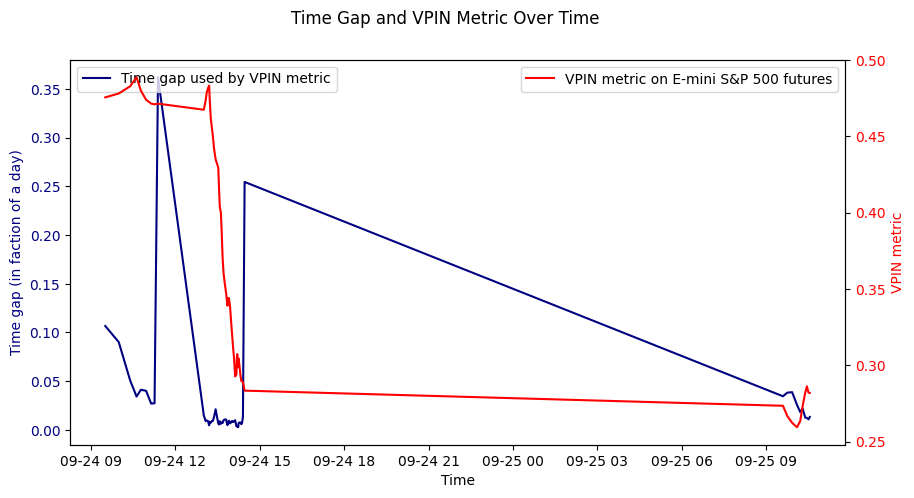

In [13]:
# Plot
fig, ax1 = plt.subplots(figsize=(10, 5))

# Left y-axis (Time gap faction of the day)
ax1.plot(df['start_bucket_time'], df['gap_time_faction_of_the_day'], color='navy', label="Time gap used by VPIN metric")
ax1.set_xlabel("Time")
ax1.set_ylabel("Time gap (in faction of a day)", color='navy')
ax1.tick_params(axis='y', labelcolor='navy')

# Right y-axis (VPIN)
ax2 = ax1.twinx()
ax2.plot(df['start_bucket_time'], df['vpin'], color='red', label="VPIN metric on E-mini S&P 500 futures")
ax2.set_ylabel("VPIN metric", color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Title and legend
fig.suptitle("Time Gap and VPIN Metric Over Time")
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()
